In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔹 Running Normal CD-Transformer on: {device}")

🔹 Running Normal CD-Transformer on: cuda


In [ ]:
class CausalDiscoveryLayer(nn.Module):
    """
    Causal Discovery Layer (Normal Version).
    Learns the causal adjacency matrix between variables.
    """
    def __init__(self, num_variables: int, hidden_dim: int = 32):
        super().__init__()
        self.num_variables = num_variables
        self.causal_logits = nn.Parameter(torch.randn(num_variables, num_variables) * 0.1)
        self.causal_transform = nn.Sequential(
            nn.Linear(num_variables, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_variables)
        )

    def get_causal_adjacency(self, temperature=0.7, hard=False):
        scaled_logits = self.causal_logits / float(temperature)
        masked_logits = scaled_logits.clone()
        eye = torch.eye(self.num_variables, device=scaled_logits.device).bool()
        masked_logits = masked_logits.masked_fill(eye, float('-inf')) # Remove diagonal
        causal_probs = torch.sigmoid(masked_logits)
        causal_probs = causal_probs * (~eye).float()
        if hard: return (causal_probs > 0.5).float()
        return causal_probs

    def apply_causal_mask(self, x, causal_adj):
        batch_size, seq_len, _ = x.shape
        causal_features = torch.zeros_like(x)
        for t in range(1, seq_len):
            prev_features = x[:, t-1, :]
            for i in range(self.num_variables):
                parents = causal_adj[:, i]
                causal_influence = torch.sum(prev_features * parents.unsqueeze(0), dim=1)
                causal_features[:, t, i] = causal_influence
        causal_features[:, 0, :] = x[:, 0, :]
        return causal_features

    def forward(self, x):
        causal_adj = self.get_causal_adjacency()
        causal_features = self.apply_causal_mask(x, causal_adj)
        B, T, V = x.shape
        enhanced = torch.zeros_like(causal_features)
        for t in range(T):
            enhanced[:, t, :] = self.causal_transform(causal_features[:, t, :])
        return causal_adj, enhanced

class CausalAttention(nn.Module):
    """Standard Self-Attention with Causal Masking (Masking future steps)."""
    def __init__(self, d_model: int, num_heads: int = 4):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, causal_adj=None, mask=None):
        B, T, _ = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Temporal mask (prevent seeing future)
        temporal_mask = torch.tril(torch.ones(T, T, device=x.device))
        scores = scores.masked_fill(temporal_mask.unsqueeze(0).unsqueeze(0) == 0, -1e9)

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, T, self.d_model)
        return self.out_proj(out), attn

class CausalTransformerBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, ff_dim: int, dropout: float = 0.1):
        super().__init__()
        self.causal_attention = CausalAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, ff_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model), nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, causal_adj, mask=None):
        attn_out, attn_w = self.causal_attention(x, causal_adj, mask)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.feedforward(x)
        x = self.norm2(x + ff_out)
        return x, attn_w

class CausalDiscoveryTransformer(nn.Module):
    """Main Normal CD-Transformer Model."""
    def __init__(self, num_variables, d_model=64, num_heads=4, num_layers=2, ff_dim=128, max_seq_len=100, prediction_horizon=1):
        super().__init__()
        self.num_variables = num_variables
        self.causal_discovery = CausalDiscoveryLayer(num_variables)
        self.input_projection = nn.Linear(num_variables, d_model)
        self.positional_encoding = self._create_positional_encoding(max_seq_len, d_model)
        self.transformer_layers = nn.ModuleList([
            CausalTransformerBlock(d_model, num_heads, ff_dim) for _ in range(num_layers)
        ])
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, ff_dim), nn.GELU(),
            nn.Linear(ff_dim, prediction_horizon)
        )
        self.dropout = nn.Dropout(0.1)

    def _create_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-(math.log(10000.0) / d_model)))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x, intervention_mask=None):
        B, T, _ = x.shape
        # 1. Learn Causal Structure
        causal_adj, causal_features = self.causal_discovery(x)

        # 2. Combine Original Input and Causal Features
        enhanced = 0.5 * x + 0.5 * causal_features
        x_emb = self.input_projection(enhanced)

        # 3. Positional Encoding
        pos = self.positional_encoding[:, :T, :].to(x.device)
        x_emb = self.dropout(x_emb + pos)

        if intervention_mask is not None:
             x_emb = x_emb * intervention_mask.unsqueeze(-1)

        attns = []
        for layer in self.transformer_layers:
            x_emb, attn = layer(x_emb, causal_adj)
            attns.append(attn)

        return self.output_projection(x_emb[:, -1, :]), causal_adj, attns

    def compute_causal_loss(self, causal_adj):
        sparsity_loss = torch.mean(causal_adj)
        dag_loss = torch.trace(causal_adj @ causal_adj) / self.num_variables
        return dag_loss, sparsity_loss

In [ ]:
def create_dataset_sliding_window(ticker, seq_len=30):
    print(f"\n📥 Downloading data for {ticker}...")
    try:
        df = yf.download(ticker, start='2020-01-01', end='2024-12-31', progress=False)
        if df.empty: raise ValueError("Empty data found!")
    except Exception as e:
        print(f"Error loading {ticker}: {e}"); return None, None, None, None

    # Feature Engineering
    df['MA5'] = df['Close'].rolling(5).mean()
    df['MA20'] = df['Close'].rolling(20).mean()
    df['Returns'] = df['Close'].pct_change()
    features = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA5', 'MA20', 'Returns']
    df = df[features].dropna()

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # --- SLIDING WINDOW LOGIC ---
    X, y = [], []
    for i in range(len(scaled_data) - seq_len):
        X.append(scaled_data[i : i + seq_len])
        y.append(scaled_data[i + seq_len, 0]) # Target: Close Price

    X, y = np.array(X), np.array(y)
    split = int(0.8 * len(X))

    train_ds = TensorDataset(torch.FloatTensor(X[:split]), torch.FloatTensor(y[:split]))
    test_ds = TensorDataset(torch.FloatTensor(X[split:]), torch.FloatTensor(y[split:]))

    return DataLoader(train_ds, batch_size=32, shuffle=True), DataLoader(test_ds, batch_size=32, shuffle=False), scaler, features

In [ ]:
def plot_metrics_panel(y_true, y_pred, ticker, metrics):
    errors = y_true - y_pred
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.suptitle(f"Performance Evaluation: {ticker}", fontsize=16, fontweight='bold')

    # 1. Actual vs Predicted Prices
    axes[0,0].plot(y_true[-100:], label='Actual', color='#1f77b4')
    axes[0,0].plot(y_pred[-100:], label='Predicted', color='#ff7f0e', linestyle='--')
    axes[0,0].set_title("Actual vs Predicted (Last 100 days)")
    axes[0,0].legend()
    axes[0,0].text(0.05, 0.95, f"MAE: {metrics['MAE']:.3f}\nRMSE: {metrics['RMSE']:.3f}\nR2: {metrics['R2']:.3f}",
                   transform=axes[0,0].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    # 2. Error over Time
    axes[0,1].plot(errors, color='#2ca02c'); axes[0,1].axhline(0, color='black')
    axes[0,1].set_title("Error Time Series")

    # 3. Error Distribution
    sns.histplot(errors, kde=True, ax=axes[1,0], color='#9467bd')
    axes[1,0].set_title("Error Distribution")

    # 4. Residuals vs Actual
    axes[1,1].scatter(y_true, errors, alpha=0.3, color='#d62728'); axes[1,1].axhline(0, color='black', linestyle='--')
    axes[1,1].set_title("Residuals vs Actual Prices")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

def plot_causal_heatmap(model, features, ticker):
    model.eval()
    with torch.no_grad():
        adj = model.causal_discovery.get_causal_adjacency().cpu().numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(adj, xticklabels=features, yticklabels=features, cmap="Blues", annot=True, fmt=".2f")
    plt.title(f"Causal Adjacency Matrix (Invention) - {ticker}"); plt.show()

def run_intervention_analysis(model, test_loader, features, scaler, base_mae, ticker):
    effects = {}
    X_all, y_all = [], []
    for bx, by in test_loader: X_all.append(bx); y_all.append(by)
    X_test = torch.cat(X_all).to(device)
    y_test = torch.cat(y_all).numpy()

    for i, f_name in enumerate(features):
        # Intervene: Set feature 'i' to 0.0
        X_mod = X_test.clone(); X_mod[:, :, i] = 0.0
        with torch.no_grad(): pred_mod, _, _ = model(X_mod)

        dummy = np.zeros((len(pred_mod), len(features)))
        dummy[:, 0] = pred_mod.cpu().numpy().flatten(); p_real = scaler.inverse_transform(dummy)[:, 0]
        dummy[:, 0] = y_test; y_real = scaler.inverse_transform(dummy)[:, 0]

        # Calculate how much the error increased
        effects[f_name] = mean_absolute_error(y_real, p_real) - base_mae

    plt.figure(figsize=(10, 5))
    s = pd.Series(effects).sort_values()
    sns.barplot(x=s.values, y=s.index, palette="viridis")
    plt.title(f"Sensitivity Analysis (Intervention) - {ticker}"); plt.show()


📥 Downloading data for GOOGL...
   🚀 Training Normal CD-Transformer for GOOGL...
      Epoch 5: Loss = 0.10934
      Epoch 10: Loss = 0.08753
      Epoch 15: Loss = 0.07129
      Epoch 20: Loss = 0.05931


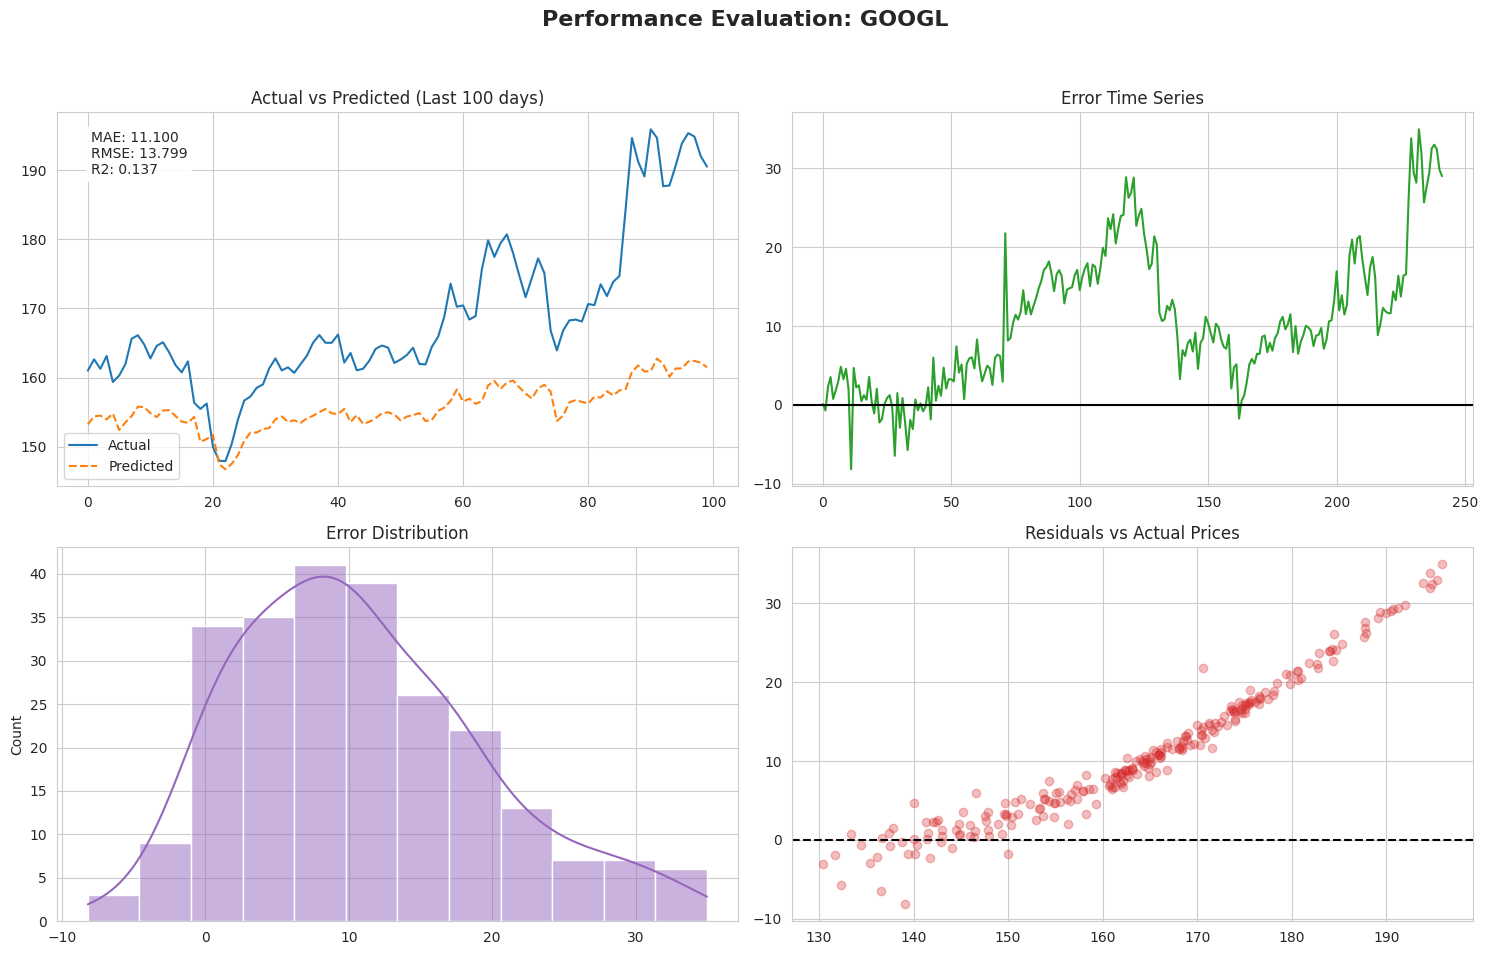

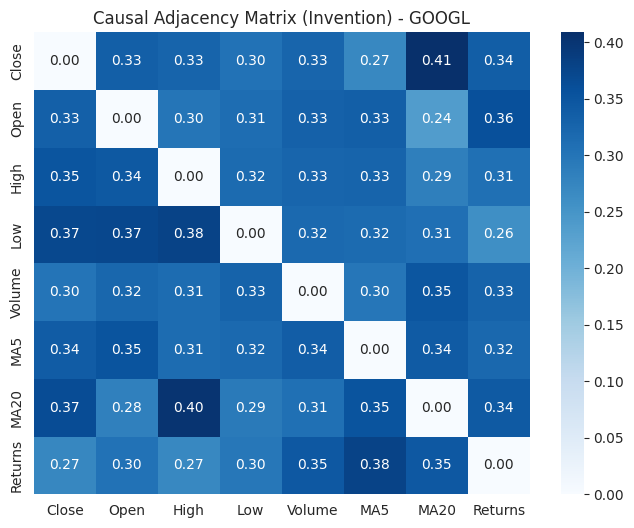

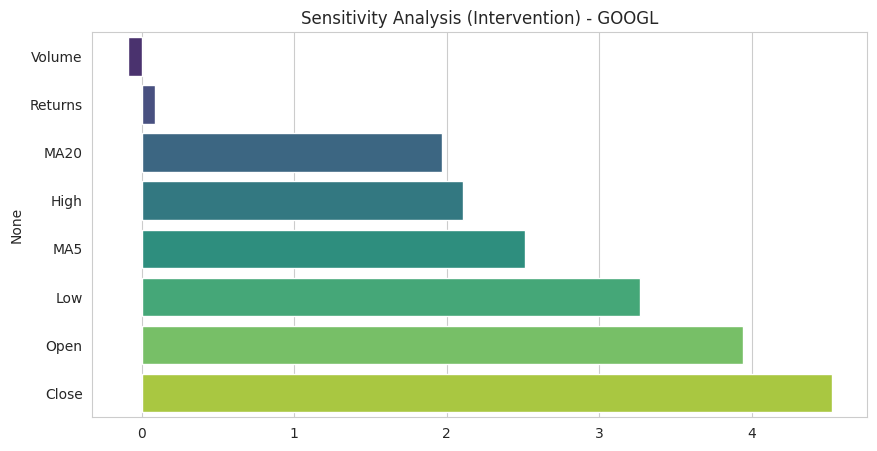


📥 Downloading data for AAPL...
   🚀 Training Normal CD-Transformer for AAPL...
      Epoch 5: Loss = 0.10571
      Epoch 10: Loss = 0.08695
      Epoch 15: Loss = 0.07130
      Epoch 20: Loss = 0.05911


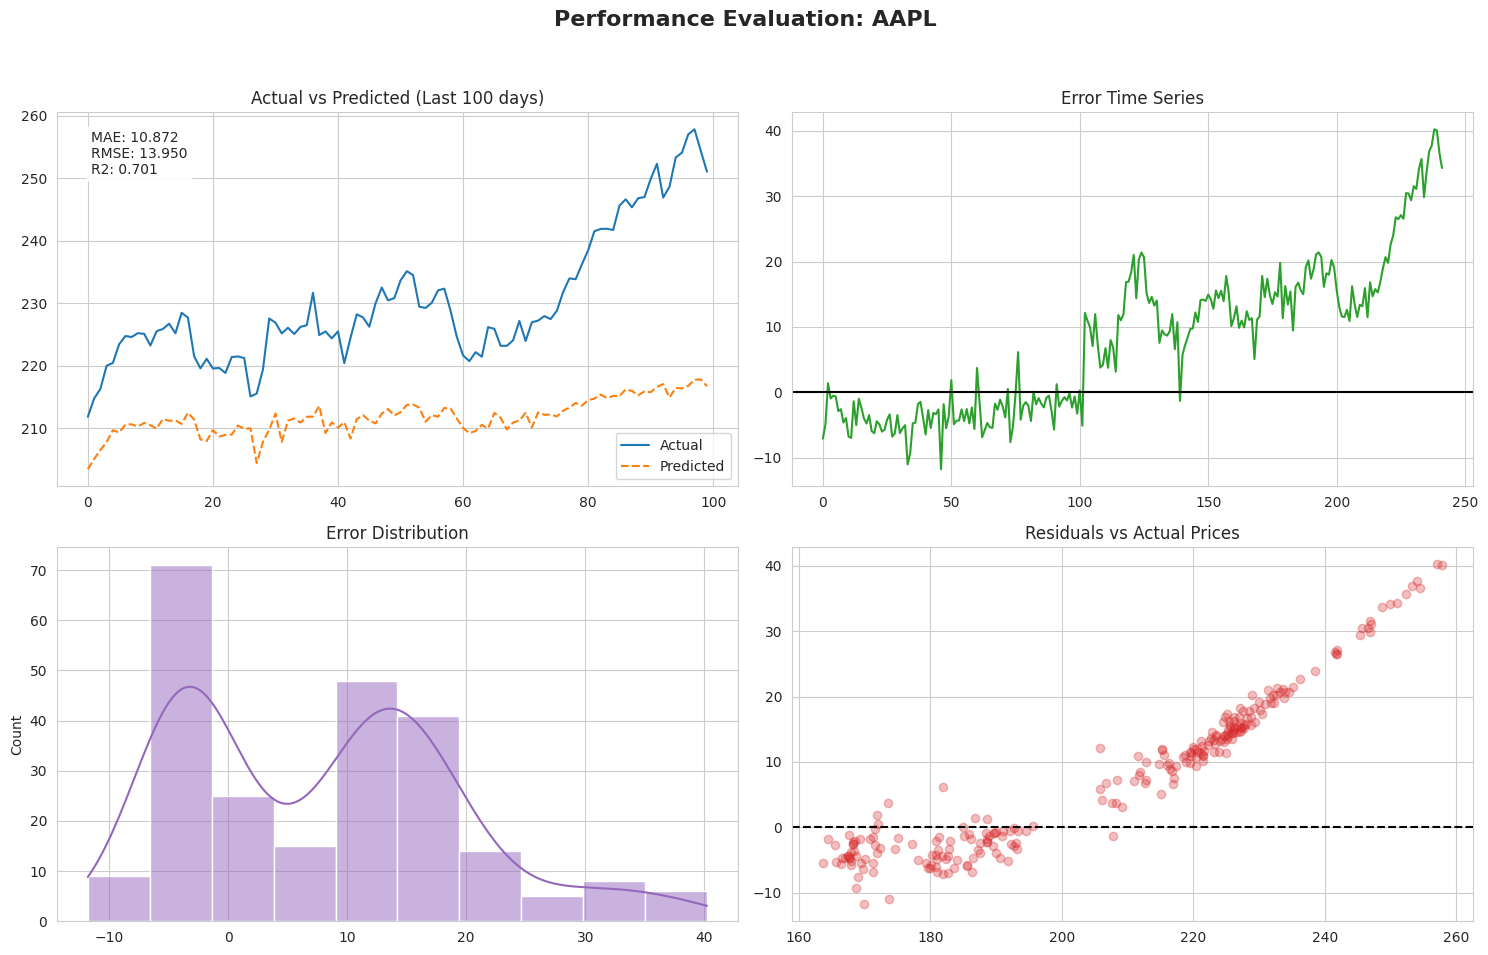

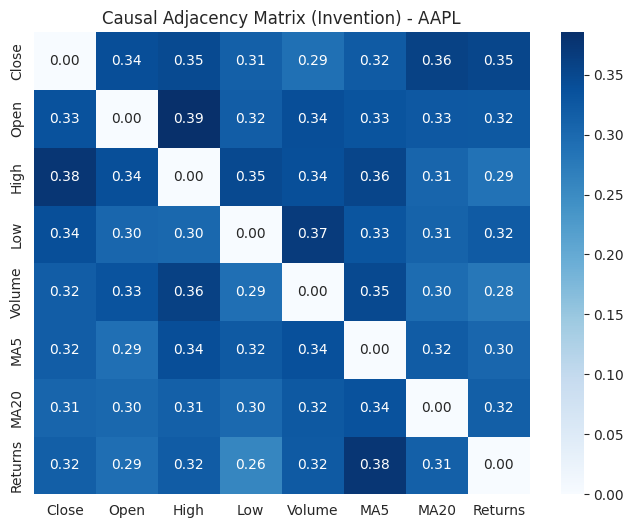

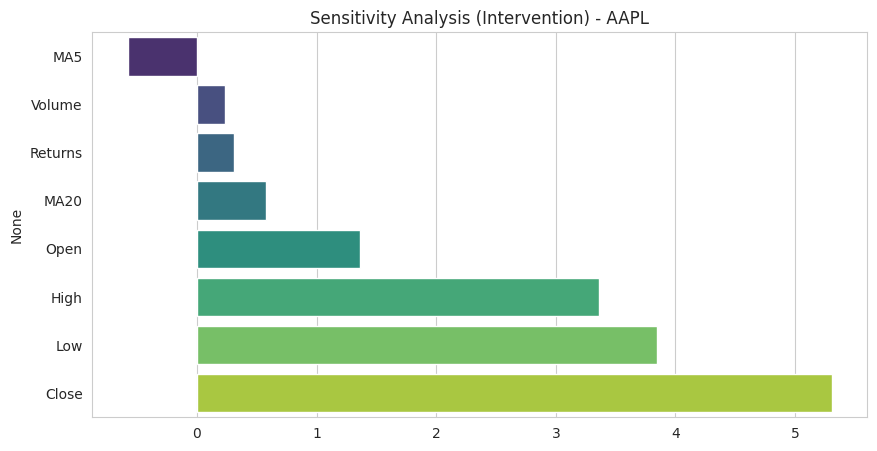


📥 Downloading data for TSLA...
   🚀 Training Normal CD-Transformer for TSLA...
      Epoch 5: Loss = 0.12086
      Epoch 10: Loss = 0.10293
      Epoch 15: Loss = 0.08534
      Epoch 20: Loss = 0.07699


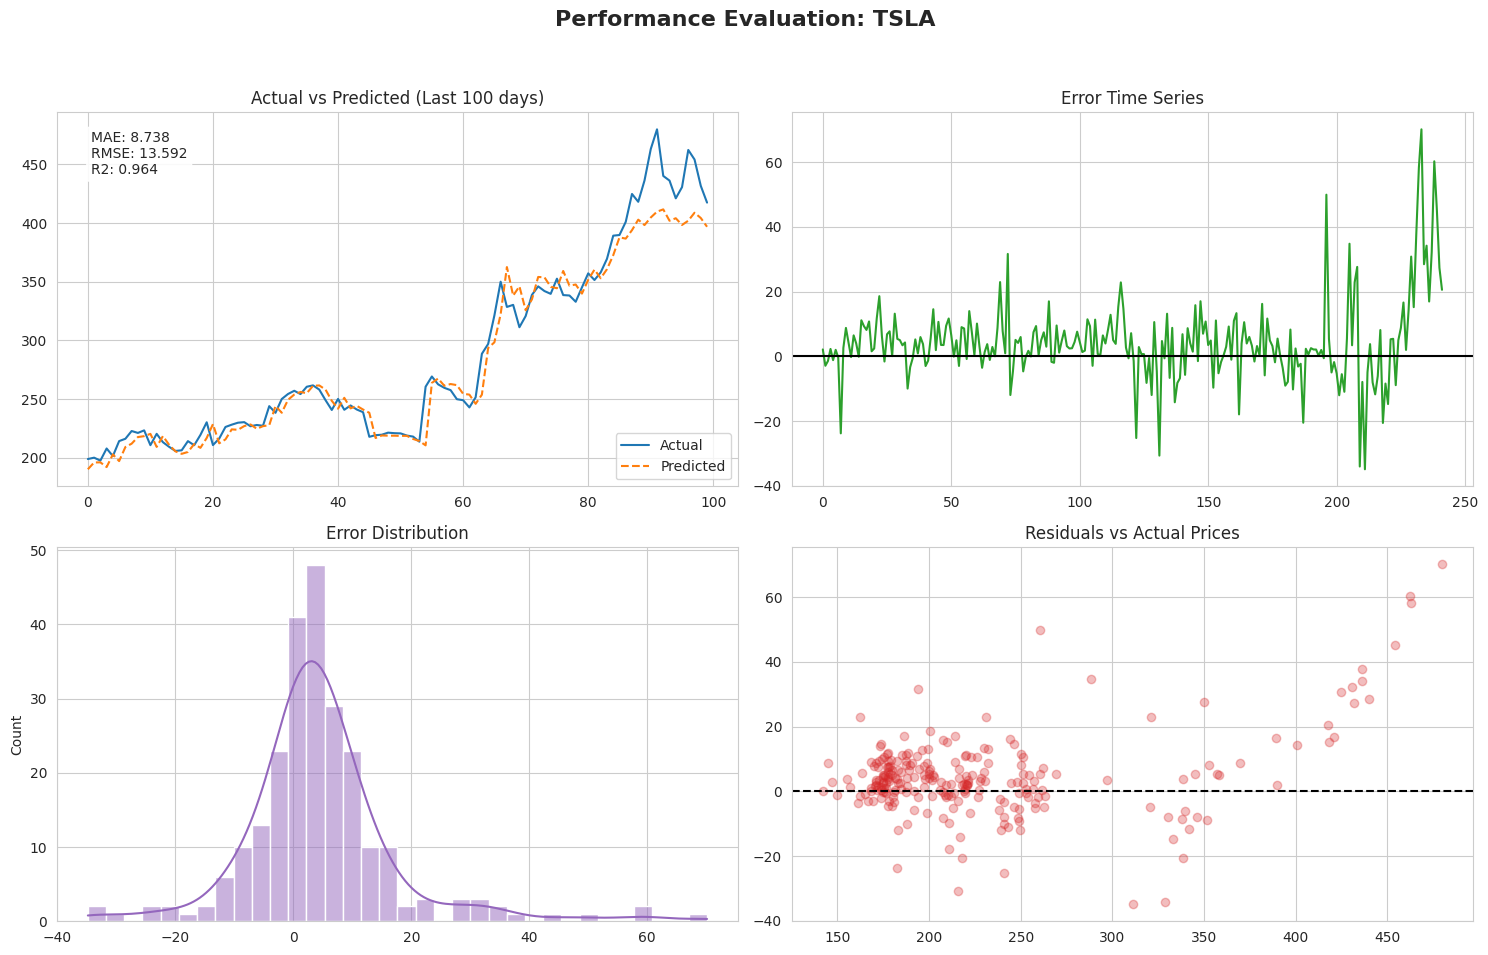

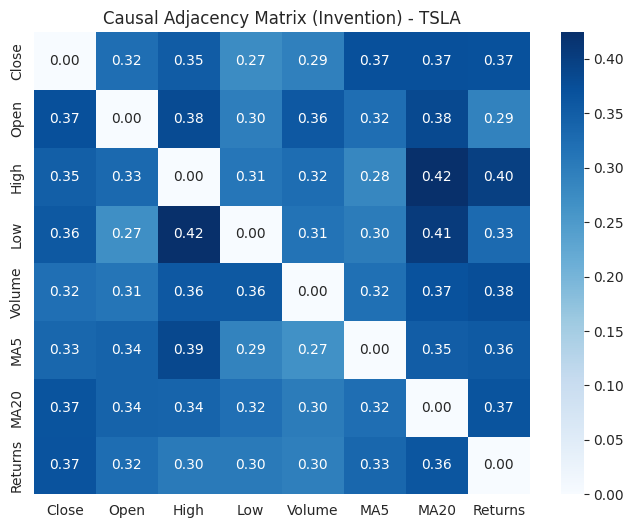

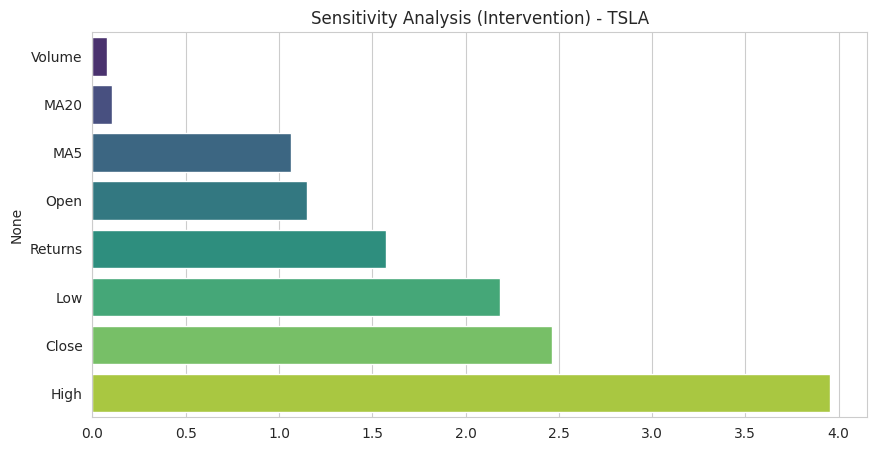


📊 --- COMPARISON RESULTS ---
  Ticker        MAE       RMSE        R2
0  GOOGL  11.100426  13.799276  0.136601
1   AAPL  10.872273  13.950023  0.701405
2   TSLA   8.737548  13.592026  0.963769


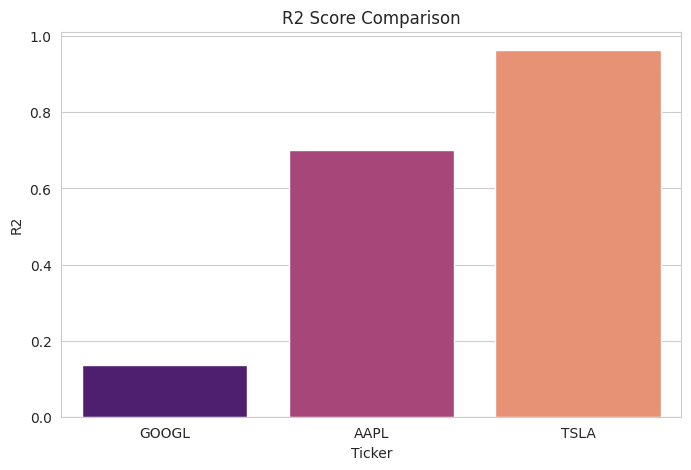

In [ ]:
# ==============================================================================
# PART 5: MAIN EXECUTION
# ==============================================================================
tickers = ['GOOGL', 'AAPL', 'TSLA']
comparison_results = []

for ticker in tickers:
    train_loader, test_loader, scaler, features = create_dataset_sliding_window(ticker)
    if train_loader is None: continue

    # Initialize Model (Normal Version)
    model = CausalDiscoveryTransformer(num_variables=len(features), d_model=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print(f"   🚀 Training Normal CD-Transformer for {ticker}...")
    model.train()
    for epoch in range(20): # 20 Epochs
        epoch_loss = 0
        for bx, by in train_loader:
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()
            preds, adj, _ = model(bx)

            # Standard Loss Function for Normal Version
            mse_loss = F.mse_loss(preds.squeeze(), by)
            dag_loss, sparsity_loss = model.compute_causal_loss(adj)
            loss = mse_loss + 0.05 * dag_loss + 0.05 * sparsity_loss

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % 5 == 0: print(f"      Epoch {epoch+1}: Loss = {epoch_loss/len(train_loader):.5f}")

    # Evaluation
    model.eval()
    preds_list, true_list = [], []
    with torch.no_grad():
        for bx, by in test_loader:
            bx = bx.to(device)
            p, _, _ = model(bx)
            preds_list.append(p.cpu().numpy())
            true_list.append(by.numpy())

    preds = np.concatenate(preds_list).flatten(); targets = np.concatenate(true_list).flatten()

    # Inverse Transform for real prices
    dummy = np.zeros((len(preds), len(features)))
    dummy[:, 0] = preds; y_pred_real = scaler.inverse_transform(dummy)[:, 0]
    dummy[:, 0] = targets; y_true_real = scaler.inverse_transform(dummy)[:, 0]

    mae = mean_absolute_error(y_true_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    r2 = r2_score(y_true_real, y_pred_real)
    res = {"Ticker": ticker, "MAE": mae, "RMSE": rmse, "R2": r2}
    comparison_results.append(res)

    # Visualizations
    plot_metrics_panel(y_true_real, y_pred_real, ticker, res)
    plot_causal_heatmap(model, features, ticker)
    run_intervention_analysis(model, test_loader, features, scaler, mae, ticker)

# Comparison
print("\n📊 --- COMPARISON RESULTS ---")
df_comp = pd.DataFrame(comparison_results)
print(df_comp)
plt.figure(figsize=(8, 5))
sns.barplot(data=df_comp, x='Ticker', y='R2', palette='magma')
plt.title("R2 Score Comparison"); plt.show()
